# Imports

In [11]:
import spacy
import pandas as pd
import numpy as np
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.vectors import Vectors
from tqdm import tqdm
tqdm.pandas()


## Get data

In [27]:
from datasets import load_dataset

df = load_dataset("ESGBERT/action_500")["train"]


In [28]:
for i in range(10,15):
    print(df[i])

{'Unnamed: 0': 10, 'text': 'John McCarroll For and on behalf of Deloitte Ireland LLP Chartered Accountants and Statutory Audit Firm Deloitte & Touche House, Earlsfort Terrace, Dublin 2 Dublin 5 March 2020 Notes: An audit does not provide assurance on the maintenance and integrity of the website, including controls used to achieve this, and in particular on whether any changes may have occurred to the financial statements since first published.', 'action': 0}
{'Unnamed: 0': 11, 'text': 'Our audit procedures relating to these matters were designed in the context of our audit of the financial statements as a whole, and not to express an opinion on individual accounts or disclosures.', 'action': 0}
{'Unnamed: 0': 12, 'text': 'We review whether the statement on pages 50 to 53 reflects the Company’s compliance with the seven provisions of the Combined Code specified for our review by the Listing Rules, and we report if it does not.', 'action': 0}
{'Unnamed: 0': 13, 'text': 'We planned and pe

We'll use the following example sentence

In [30]:
sentence = df["text"][67]
sentence

'Failure to comply with legal or regulatory requirements and/or changes.'

## Clean data

In [41]:
punctuations = string.punctuation

nlp = spacy.load('en_core_web_md')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Remove OOV words
    mytokens = [ word for word in mytokens if not word.is_oov ]
    
    # Lemmatise + lower case
    mytokens = [ word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

spacy_tokenizer(sentence)

['failure', 'comply', 'legal', 'regulatory', 'requirement', 'and/or', 'change']

## Calculate word frequencies

In [42]:
from collections import Counter

tokenFreq = Counter()

def countWordFrequencies(example):
    tokens = spacy_tokenizer(example["text"])
    tokenFreq.update(tokens)
    
df.map(countWordFrequencies)

tokenFreq.most_common(10)

Map: 100%|█████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 131.00 examples/s]


[('Group', 110),
 ('Board', 78),
 ('risk', 72),
 ('business', 64),
 ('customer', 59),
 ('company', 59),
 ('Committee', 55),
 ('audit', 48),
 ('financial', 48),
 ('report', 47)]

In [43]:
tokenFreq.total()

7793

In [44]:
len(tokenFreq.keys())

2248

In [69]:
VOCAB_SIZE = 1000

In [71]:
print("Most frequent")
print(tokenFreq.most_common(10))
print("Least frequent")
print(tokenFreq.most_common(VOCAB_SIZE)[-10:])


Most frequent
[('Group', 110), ('Board', 78), ('risk', 72), ('business', 64), ('customer', 59), ('company', 59), ('Committee', 55), ('audit', 48), ('financial', 48), ('report', 47)]
Least frequent
[('claim', 2), ('GB', 2), ('Staff', 2), ('incorporate', 2), ('oversight', 2), ('criminal', 2), ('sanction', 2), ('forbearance', 2), ('sale', 2), ('assure', 2)]


In [72]:
tokenMap = {k: i+1 for i, (k, _) in enumerate(tokenFreq.most_common(VOCAB_SIZE-1))}
tokenMap["<oov>"]=0
tokenMapInverse = {v: k for k,v in tokenMap.items()}
print(list(tokenMap.items())[0:10])
print([tokenMapInverse[i] for i in range(10)])

[('Group', 1), ('Board', 2), ('risk', 3), ('business', 4), ('customer', 5), ('company', 6), ('Committee', 7), ('audit', 8), ('financial', 9), ('report', 10)]
['<oov>', 'Group', 'Board', 'risk', 'business', 'customer', 'company', 'Committee', 'audit', 'financial']


## Simple model - BOW

In [73]:
def embed_sentence_BOW(example):
    """
    Simple BOW
    """
    embedding = np.zeros(VOCAB_SIZE)
    tokens = spacy_tokenizer(example["text"])
    for token in tokens:
        try:
            tokenIndex = tokenMap[token]
        except KeyError: # Out of vocabulary
            tokenIndex = 0
        embedding[tokenIndex] = embedding[tokenIndex] + 1
    return {"embedding": embedding}
    
sentence = df[302]
sentence_embedding = embed_sentence_BOW(sentence)

print(sentence_embedding)
print(sentence_embedding.shape)
print(sentence)
print("What this means: ")

for i in range(VOCAB_SIZE):
    if sentence_embedding[i]:
        print(f"Token {i} '{tokenMapInverse[i]}' occurs {sentence_embedding[i]} time in sentence.")

{'embedding': array([4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 

AttributeError: 'dict' object has no attribute 'shape'

In [74]:
df_with_embeddings = df.map(embed_sentence_BOW)
df_with_embeddings

Map: 100%|█████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 140.90 examples/s]


Dataset({
    features: ['Unnamed: 0', 'text', 'action', 'embedding'],
    num_rows: 500
})

In [76]:
# df_with_embeddings[302]

## Classify

In [77]:
X = np.stack(df_with_embeddings["embedding"])
X.shape

(500, 1000)

In [78]:
X[302:303,]

array([[4., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 

In [84]:
y = np.array(df_with_embeddings["action"])
y

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,

In [85]:
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22141)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")



X_train shape: (375, 1000)
X_test shape: (125, 1000)
y_train shape: (375,)
y_test shape: (125,)


In [87]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=2, random_state=22141, class_weight="balanced", n_estimators=300)
clf.fit(X_train, y_train)

print("Done")

Done
CPU times: user 210 ms, sys: 32.4 ms, total: 243 ms
Wall time: 284 ms


## Evaluate

In [88]:

predictions = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.80      0.84      0.82        80
           1       0.68      0.62      0.65        45

    accuracy                           0.76       125
   macro avg       0.74      0.73      0.73       125
weighted avg       0.76      0.76      0.76       125



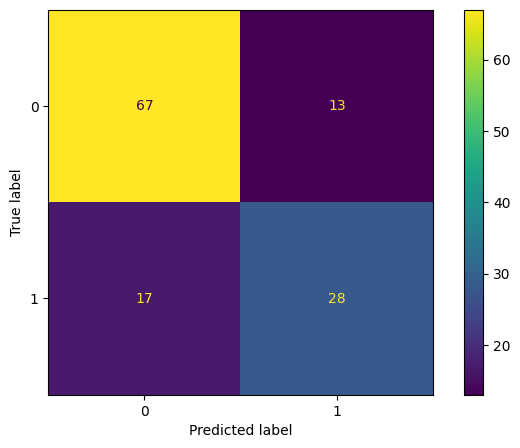

In [89]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
print(classification_report(y_test, predictions))
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, predictions),
    display_labels=clf.classes_,
)

cmp.plot(ax=ax)
plt.show();

## What's next?
### Building further on this example.
The example above is to illustrate the theory of embeddings. In reality, you can build pipelines super easily with SpaCy (if you prioritize speed) or HuggingFace transfomers (if you prioritize accuracy)

https://medium.com/@ycouble/training-and-integrating-a-custom-text-classifier-to-a-spacy-pipeline-b19e6a132487

### Fundamental limitations of the BOW approach
1. We're just counting words, which means we don't consider the order of words in a sentence.
2. Lots of OOV tokens that are modelled incorrectly, which we don't like.
3. 